In [3]:
import numpy as np
import pandas as pd
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

from os import path, getcwd
from glob import glob
import pykalman

In [4]:
data_dir = '../data/workshop-content18/3-snc/data/'
ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]
for bn in ais_basenames:
    print(bn)

PMV_AIS_NewWestminster_Current.txt
PMV_AIS_Deltaport_Current.txt
PMV_AIS_Deltaport_History.txt
PMV_AIS_NewWestminster_History.txt


In [5]:
delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)

In [10]:
#max_rows=int(3e7)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t',
    parse_dates=['ReceivedTime'],usecols=['UserID','ROT','SOG','Longitude','Latitude',
                                         'TrueHeading','ReceivedTime','TimeStamp'])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
delta_cur = delta_cur.dropna(axis=0)
delta_cur.head()

,UserID,ROT,SOG,Longitude,Latitude,TrueHeading,TimeStamp,ReceivedTime
0,316005621,-127.0,0.1,-122.77156,49.23065,511.0,24.0,2013-10-22 01:05:24.510
1,316018851,0.0,1.7,-123.05445,49.29853,110.0,24.0,2013-10-22 01:05:25.400
2,316003679,-127.0,0.1,-123.10751,49.31308,511.0,24.0,2013-10-22 01:05:25.853
3,316014621,127.0,12.3,-123.09534,49.29940,210.0,26.0,2013-10-22 01:05:26.027
4,316005721,-127.0,0.1,-123.10684,49.31094,511.0,25.0,2013-10-22 01:05:26.620


In [12]:
if delta_cur.isna().iloc[-1,:].sum() > 10:
    delta_cur = delta_cur.iloc[:-1, :]

print('# na:', (delta_cur.isna().sum(axis=1) > 5).sum())

# na: 0


In [13]:
delta_cur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2560654 entries, 0 to 2560653
Data columns (total 8 columns):
UserID          object
ROT             float64
SOG             float64
Longitude       float64
Latitude        float64
TrueHeading     float64
TimeStamp       float64
ReceivedTime    datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 255.8+ MB


In [14]:
#extract only lat and lon needed
mask = (delta_cur['Longitude']>-127)&(delta_cur['Longitude']<-120)
mask = mask & (delta_cur['Latitude']>48)|(delta_cur['Latitude']<50)

delta_cur = delta_cur[mask]

In [15]:
delta_cur.head()

,UserID,ROT,SOG,Longitude,Latitude,TrueHeading,TimeStamp,ReceivedTime
0,316005621,-127.0,0.1,-122.77156,49.23065,511.0,24.0,2013-10-22 01:05:24.510
1,316018851,0.0,1.7,-123.05445,49.29853,110.0,24.0,2013-10-22 01:05:25.400
2,316003679,-127.0,0.1,-123.10751,49.31308,511.0,24.0,2013-10-22 01:05:25.853
3,316014621,127.0,12.3,-123.09534,49.29940,210.0,26.0,2013-10-22 01:05:26.027
4,316005721,-127.0,0.1,-123.10684,49.31094,511.0,25.0,2013-10-22 01:05:26.620


In [16]:
np.max(delta_cur['Longitude'])

105.93208999999999

In [17]:
delta_cur.shape

(2502883, 8)

In [18]:
nPoints_by_UserID = pd.value_counts(delta_cur.UserID)
nPoints_threshold = 1000
print('num rows for which userid count <= 1000:', nPoints_by_UserID.loc[nPoints_by_UserID <= 1000].values.sum())
userID_allowed = nPoints_by_UserID.index[nPoints_by_UserID > nPoints_threshold]

num rows for which userid count <= 1000: 54122


In [19]:
delta_cur = delta_cur[delta_cur['UserID'].isin(list(userID_allowed))]

In [20]:
delta_cur.iloc[0,0]

316005621

In [21]:
# As the first try, we choose one ship only
UserID = delta_cur.iloc[0,0]

In [41]:
df = delta_cur[delta_cur['UserID']==UserID]
df = df.drop(['UserID'],axis=1)
df['Date'] = df['ReceivedTime'].apply(lambda x: x.day)
df = df.sort_values(by=['Date','TimeStamp','ReceivedTime']).reset_index(drop=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 8 columns):
ROT             8807 non-null float64
SOG             8807 non-null float64
Longitude       8807 non-null float64
Latitude        8807 non-null float64
TrueHeading     8807 non-null float64
TimeStamp       8807 non-null float64
ReceivedTime    8807 non-null datetime64[ns]
Date            8807 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 550.5 KB


In [43]:
df.head()

,ROT,SOG,Longitude,Latitude,TrueHeading,TimeStamp,ReceivedTime,Date
0,-127.0,8.7,-123.07674,49.12093,511.0,3.0,2013-10-22 19:54:05.117,22
1,-127.0,8.8,-123.08287,49.11828,511.0,3.0,2013-10-22 19:56:05.383,22
2,-127.0,8.7,-123.08971,49.11638,511.0,3.0,2013-10-22 19:58:04.353,22
3,-127.0,0.1,-122.77136,49.23076,511.0,4.0,2013-10-22 01:14:05.237,22
4,-127.0,0.1,-122.77154,49.23061,511.0,4.0,2013-10-22 01:18:05.190,22


In [44]:
#water = gpd.read_file('./british_columbia_coastline.shp')

In [45]:
df.shape

(8807, 8)

In [46]:
np.max(df['ReceivedTime'])

Timestamp('2013-10-31 23:30:32.597000')

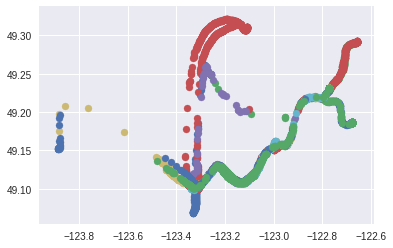

In [47]:
plt.plot()
timestamp_list =np.unique(df['Date'])
for i in range(len(timestamp_list)):
    mask = df['Date'] == timestamp_list[i]
    plt.scatter(df.loc[mask,'Longitude'],df.loc[mask,'Latitude'])
plt.show()

In [51]:
df[df['Date']== 25].head(20)

,ROT,SOG,Longitude,Latitude,TrueHeading,TimeStamp,ReceivedTime,Date
5199,-127.0,9.7,-123.31161,49.17764,511.0,1.0,2013-10-25 06:16:01.983,25
5200,-127.0,8.7,-122.77347,49.22871,511.0,1.0,2013-10-25 11:13:02.773,25
5201,-127.0,5.9,-122.77166,49.23039,511.0,1.0,2013-10-25 11:14:01.950,25
5202,-127.0,0.4,-122.77143,49.23073,511.0,1.0,2013-10-25 11:15:01.933,25
5203,-127.0,0.0,-122.77142,49.23073,511.0,1.0,2013-10-25 11:19:01.997,25
5204,-127.0,0.0,-122.77145,49.23069,511.0,1.0,2013-10-25 11:29:02.053,25
5205,-127.0,0.0,-122.77130,49.23066,511.0,1.0,2013-10-25 13:29:01.990,25
5206,-127.0,0.0,-122.77150,49.23078,511.0,1.0,2013-10-25 13:32:03.990,25
5207,-127.0,0.0,-122.77144,49.23070,511.0,1.0,2013-10-25 14:38:01.920,25
5208,-127.0,0.0,-122.77148,49.23069,511.0,1.0,2013-10-25 16:44:01.890,25


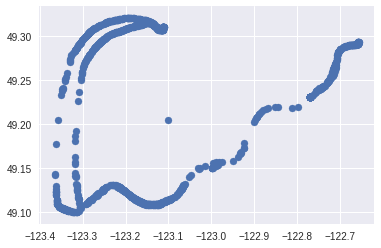

In [52]:
plt.plot()
mask = df['Date'] == 24
plt.scatter(df.loc[mask,'Longitude'],df.loc[mask,'Latitude'])
plt.show()